# Ocean Dependence

Visualizing marine protein consumption (as a proprotion of diet) in countries with high food insecurity.

*Author: Rachel Thoms
<br>Created: 04 Aug 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- [Dorling Cartogram](https://vega.github.io/vega/examples/dorling-cartogram/) 
- Size is proportion of protein consumption from marine protein (%) color is food insecurity (%)

## Data

- Data: ow_widget_territory (full datasets - [foo_061_rw0_blue_food_supply](https://resourcewatch.carto.com/u/wri-rw/dataset/foo_061_rw0_blue_food_supply_edit) & [foo_064_rw0_food_insecurity](https://resourcewatch.carto.com/u/wri-rw/dataset/foo_064_rw0_food_insecurity_edit))
- Resource Watch: [explore page](https://resourcewatch.org/data/explore/9e1b3cad-db6f-44b0-b6fb-048df7b6c680)
- Source: [FAO Food Balance Sheet](http://www.fao.org/faostat/en/#data/FBS) & [FAO Food Security Indicators](http://www.fao.org/faostat/en/#data/FS)

## Preparation

### Aliasing and Inserting Data

#### Queries

Protein Supply

```sql
INSERT INTO ow_widget_territory(section, widget, gid_0, name_0, variable, date, value, unit)

SELECT 'indicator' AS section, 'ocean dependence' AS widget, alias.iso AS gid_0, alias.name_0 AS name_0, CONCAT(data.element, ' - ', data.type) AS variable, data.year as date, data.value AS value, data.unit AS unit 

FROM 

(SELECT area, year, unit, element, type, SUM (value) AS value 
FROM foo_061_rw0_blue_food_supply_edit WHERE element = 'Protein supply quantity (g/capita/day)' AND area != 'World' AND year = 2018 GROUP BY area, year, unit, element, type) data

LEFT JOIN ow_aliasing_countries AS alias ON  alias.alias = data.area WHERE alias.iso IS NOT NULL
```

- rows before: 153173
- rows inserted: 334
- rows after: 153517

Food Insecurity

```sql
INSERT INTO ow_widget_territory(section, widget, gid_0, name_0, variable, date, value, unit)
SELECT 'indicator' AS section, 'ocean dependence' AS widget, alias.iso AS gid_0, alias.name_0 AS name_0, 'FoodInsecurity_Prevalence' AS variable, '20182020' AS date, data.y20182020 AS value, unit AS unit 
FROM (SELECT area, y20182020, unit FROM foo_064_rw0_food_insecurity_edit) data
LEFT JOIN ow_aliasing_countries AS alias ON alias.alias = data.area WHERE alias.iso IS NOT NULL
```

- rows before: 153517
- rows inserted: 204
- rows after: 153721
- countries: 204

## Vega

In [4]:
import json
from vega import Vega
from IPython.display import display

In [5]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [7]:
widget_width = 800
widget_height = 400

### Version 1 - Food Security as Size

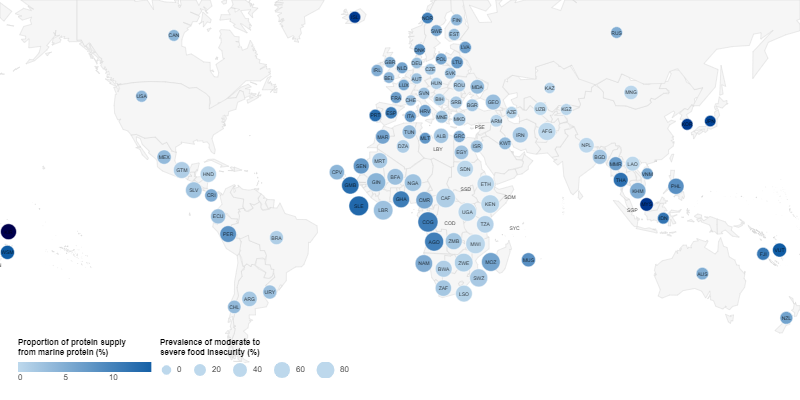

In [4]:
spec=json.loads("""{
  "autosize": "none",
  "data": [
    {
      "name": "protein",
      "format": {
        "property": "rows",
        "type": "json"
      },
      "transform": [
        {
          "as": "variable",
          "expr": "substring(datum.variable,41)",
          "type": "formula"
        },
        {
          "as": "variable",
          "expr": "replace(datum.variable,/ /, '_')",
          "type": "formula"
        },
        {
          "as": "variable",
          "expr": "replace(datum.variable,/-/, '_')",
          "type": "formula"
        },
        {
          "field": "variable",
          "groupby": [
            "gid_0"
          ],
          "type": "pivot",
          "value": "value"
        },
        {
          "as": "marine_protein_percent",
          "expr": "datum.Grand_Total === 0 ? null : (datum.Ocean_Sourced_Food/ datum.Grand_Total)*100",
          "type": "formula"
        }
      ],
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT date AS year, value, variable, gid_0 FROM ow_widget_territory WHERE section = 'indicator' AND widget = 'ocean dependence' AND variable != 'FoodInsecurity_Prevalence' AND value IS NOT NULL ORDER BY gid_0 ASC"
    },
    {
      "format": {
        "property": "features",
        "type": "json"
      },
      "name": "source",
      "url": "https://wri-rw.carto.com/api/v2/sql?format=GeoJSON&q=SELECT ST_Centroid(gadm.the_geom) AS the_geom, data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data INNER JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 ORDER BY gid_0 ASC"
    },
    {
      "name": "centroids",
      "source": "source",
      "transform": [
        {
          "as": "x_cart",
          "expr": "test(/KIR/, datum.properties.gid_0) ? 175 : test(/WSM/, datum.properties.gid_0) ? 175: test(/TON/, datum.properties.gid_0) ? 180 : datum.geometry.coordinates[0]",
          "type": "formula"
        },
        {
          "as": "y_cart",
          "expr": "test(/KIR/, datum.properties.gid_0) ? -5: test(/WSM/, datum.properties.gid_0) ? -10: test(/TON/, datum.properties.gid_0) ? -18: datum.geometry.coordinates[1]",
          "type": "formula"
        },

        {
          "fields": [
            "x_cart",
            "y_cart"
          ],
          "projection": "projection",
          "type": "geopoint"
        }
      ]
    },
    {
      "format": {
        "property": "rows",
        "type": "json"
      },
      "name": "foodSecurity",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data INNER JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 AND value IS NOT NULL ORDER BY gid_0 ASC",
      "transform": [
        {
          "as": [
            "protein"
          ],
          "fields": [
            "gid_0"
          ],
          "from": "protein",
          "key": "gid_0",
          "type": "lookup",
          "values": [
            "marine_protein_percent"
          ]
        },
        {
          "as": [
            "x","y"
          ],
          "fields": [
            "gid_0"
          ],
          "from": "centroids",
          "key": "properties[gid_0]",
          "type": "lookup",
          "values": [
            "x", "y"
          ]
        }
      ]
    },
    {
      "name": "transformed",
      "source": "foodSecurity",
      "transform": [
        {
          "as": "size",
          "expr": "3 + sqrt(scale('size', datum.value))/2.5",
          "type": "formula"
        },
        {
          "type": "force",
          "forces": [
            {
              "force": "collide",
              "radius": {
                "field": "size"
              },
              "iterations": 200,
              "strength": 0.9
            },
            {
              "force": "x",
              "x": {
                "field": "x"
              }
            },
            {
              "force": "y",
              "y": {
                "field": "y"
              }
            }
          ]
        },
        {
          "as": "x",
          "expr": "datum.x+datum.vx",
          "type": "formula"
        },
        {
          "as": "y",
          "expr": "datum.y+datum.vy",
          "type": "formula"
        }
      ]
    },
    { "name": "geom",
    "url": "https://raw.githubusercontent.com/wri/wri-bounds/master/dist/all_countries.min.geojson",
    "format": {
      "property": "features",
      "type": "json"},
      "transform": [
        {
          "as": [
            "protein"
          ],
          "fields": [
            "properties[iso_a3]"
          ],
          "from": "protein",
          "key": "gid_0",
          "type": "lookup",
          "values": [
            "marine_protein_percent"
          ]
        },
        {
          "as": ["security"
          ],
          "fields": [
            "properties[iso_a3]"
          ],
          "from": "foodSecurity",
          "key": "gid_0",
          "type": "lookup",
          "values": ["value"]
        }
      ]
    }
  ],
  "description": "A Dorling cartogram depicting marine protein supply and food insecurity.",
  "height": 400,
  "legends": [
    {
      "clipHeight": 16,
      "direction": "horizontal",
      "fill": "color",
      "gradientLength": {
        "signal": "width/6"
      },
      "gradientThickness": 10,
      "labelFontSize": 10,
      "orient": "bottom-left",
      "size": "color",
      "title": [
        "Proportion of protein supply",
        "from marine protein (%)"
      ],
      "titleFontSize": 10,
      "titleFont": "Arial",
      "type": "gradient"
    },
    {
      "clipHeight": 16,
      "direction": "horizontal",
      "labelFontSize":10,
      "orient": "bottom-left",
      "size": "size",
      "symbolFillColor": "#bdd8ec",
      "symbolStrokeColor": "white",
      "title": [
        "Prevalence of moderate to",
        "severe food insecurity (%)"
      ],
       "titleFont": "Arial",
      "titleFontSize": 10,
      "type": "symbol"
    }
  ],
  "scales": [
    {
      "domain": {
        "data": "foodSecurity",
        "field": "value"
      },
      "name": "size",
      "range": {"signal": "[height/4,height]"}
    },
    {
      "domain": {
        "data": "foodSecurity",
        "field": "protein"
      },
      "domainMax": 14,
      "name": "color",
      "nice": true,
      "range": [
        "#bdd8ec",
        "#145fa6"
      ],
      "type": "linear"
    }
  ],
  "width": 800,
  "marks": [
    {
      "encode": {
        "enter": {
          "fill": [{"test": "isValid(datum.protein)", 
            "field": "protein",
            "scale": "color"},
            {"field": "protein","value": ["transparent"]}
          ],
          "size": {
            "field": "value",
            "scale": "size"
          },
          "stroke": [{"test": "isValid(datum.protein)", 
            "value": "white"}, {"value": "transparent"}
          ],
          "strokeWidth": {
            "value": 0.5
          },
          "tooltip": {
            "signal": "{'Country':datum.name_0, 'Proportion of protein supply from marine protein':isValid(datum.protein) ? round(datum.protein*10)/10 + '%' : 'No data', 'Prevalence of moderate to severe food insecurity': isValid(datum.value) ? format(datum.value, '.1f') + '%' : 'No data'}"
          },
          "x": {
            "field": "x"
          },
          "y": {
            "field": "y"
          }
        }
      },
      "from": {
        "data": "transformed"
      },
      "name": "circles",
      "type": "symbol",
      "zindex": 1
    },
    {
      "encode": {
        "enter": {
          "align": {
            "value": "center"
          },
          "baseline": {
            "value": "middle"
          },
          "fill": [{"test": "isValid(datum.datum.value) && isValid(datum.datum.protein)", "value": "black"}, 
            {"value": "transparent"
          }],
          "fontSize": {
            "signal": "5"
          },
          "font": {
            "value": "Arial"
          },
          "text": {
            "field": "datum.gid_0"
          }
        },
        "update": {
          "x": {
            "field": "x"
          },
          "y": {
            "field": "y"
          }
        }
      },
      "from": {
        "data": "circles"
      },
      "interactive": false,
      "type": "text",
      "zindex": 2
    },
    {
      "encode": {
        "enter": {
          "fill": {
            "value": "#f6f6f6"
          },
          "stroke": {
            "value": "#d8d8d8"
          },
          "strokeWidth": {
            "value": 0.5
          },
          "tooltip": {
            "signal": "{'Country':datum.properties.name, 'Proportion of protein supply from marine protein': isValid(datum.protein) ? round(datum.protein*10)/10 + '%' : 'No data', 'Prevalence of moderate to severe food insecurity': isValid(datum.security) ? format(datum.security, '.1f') + '%' : 'No data'}"
          }
        }
      },
      "from": {
        "data": "geom"
      },
      "transform": [
        {
          "projection": "projection",
          "type": "geoshape"
        }
      ],
      "type": "shape",
      "zindex": 0
    }
  ],
  "projections": [
    {
      "extent": {
        "signal": "[[-width/20,0],[width,height-height/4.5]]"
      },
      "clipExtent": {
        "signal": "[[0,0],[width,height-height/8]]"
      },
      "fit": {
        "signal": "data('source')"
      },
      "name": "projection",
      "type": "naturalEarth1"
    }
  ]
}""")
vegaview=dict(spec)
Vega(vegaview)

[Open the Chart in the Vega Editor](https://vega.github.io/editor/#/url/vega/N4IghgrgLg9gzgSwF4FMQC4QDsZbQGhABMwowMBtUAMxgCcBbUjUABzplZTqgE8MQHAO5wQhPlwEArOLhABfQljAM0mdjCgoEWMSCh0wWOLUaVQYUZgBuYOgjAAjADYEQKAB7sBcCI7gGOgDmABQkUBAMAHS29k6u+AAsAIwAlHoSaiCmDBDO5IoWViCxDi5unt6YdCis+QDGKGGkkTF2ZQkA5AAEnfi9APqd6eK8kpg5eQX4RQKl8RVedAI1dWCNzRHR8+X9nQC0fYPDGWNZk-kKM9kIKM5Ec+0LekEcEKyO-OgUIEEIRAMAAwgAC6o3GIFYCGsmj0tmcECy8MRV1mmCY9jwAw0Wh02O4jSwUD0lWWmE2rQA8o0jAMAMowCB0RoAgBiMBgRAA9N1wq0AOKGLAAgAqmjAzlSACpkoDgeDzvRcpd5GCQEznAIABZQKCsODoLlcoT2fZ0IRRep2WCWmAMLlgKFc6wAJi5cAAjs4APwegC8dIAogAZQMAYRFvNIKG6AEE6d1eCg7P1kShU09dt0-gDAd1WQAlSkAWW6MCEAyE-yCKCgAy0dHssDovG6AHUABKBguB7pwFD1KAIXDdP29HREBBW5s9WMAOQAIt0q0Qa1BR70YDSsLzaihhfvGrPF90dq5ugBCMeddmcgCSxgHTIQfAGAAUavDDyhj0u0907wTOdKUjOcAFVg2DbpKQLBdu26AAhABNbN-iBOM6TDAAyfdrD9DQiAgQdhywLD8iwIIIDAGs-X3LDWGolAKEQVAQT9ABOTisPNP0cKwPCCKIodcDIoxKMY2jSIYmtmOQFA2M49juKEXjcPwjhCOIkTyPEmi6OkpiWPkjiuJ41FsiVZh0DYDguB4L5smTCIalEBVpFkXRFGwFQslkJlGj0DVtV1fVDWNU1zUta0YFte1HQQZ03U9H0clIP1+RQGAACk6UpOcsP9INQwjbo6RFAYw33AwYH+EIgjAIhoigLUUAGGs7VSDDuma1r2oYfpwjAKIcyBAbSCG5RVFGqMyDaOIs0GtoERjQsS26EIivDSMpXzItS3LStq1retuCbehW07btezPGNr1vIgH37epn1fD8UC-LAj06waALnOd4Kyyk7znbMGoYABmAA2dD41BxroJB+rGuGtC8zHRaRrzGC4ILRCUMxjCw3MyaskJar-lckA-OZXzGRpjIhRMJVzHAYoPAGK0eBJJYBC0AIQi5ABpO8Cy5MatiiDQ7KHFA4BR3NOu9bp9mSAB2F1unQGbWj62sW1tehJ2UPmKEBEFTghC5pjREBeA561uaqfRZagAXhdF8XWil7gZblzHFeV5Jwc17Xol1gxeANugjejOAKGSc23ImJUpnM6hbnuKwfnZzniUIO3c9BQgNCkAdhN0dQOFLrTdCT35MtYGqiQUEFCgsxgrJszgfYc6gnKZWWLayGQ5C8kmBD6hmjCZsxvjRH4cW0XQ1XTu4iCzyFbJ92448x82V44BgBEXnQ9AAaxQBzMaHgRnA5M-3jhCVEQ3jEdFak+sHxGnm9btUgswDqPUBojQmgQGaC0ucYr1DtA6J0rp3Rem9KlKA6VMo5TygVAMIYtrdFKuVOkCAGB1AQNQXgdUwZRB6m1TK-VARRAAKydVhtQvq4shqY3YVEEm01Fo3S4f+VapYNo4JKjtIRZYKwrjXCdRsL5zrti7D2U8mZzx3Q5A9R8z0mx2zeh9L6M0wC-X+rjQGwM4YQ2hnmWGSMGAIwsfLdC6NxqOOsSeDGqNujAUjOYkInQCxgTpH0To84FzBPjMWcJIp+RHE6AhDsBZYkIWLGBJJBYEKxLDCWTJb4ABqsSFzFljLE1kdJIl7H5LBWJHZBYxL2O7WJgs5zFL2MGMMLTejBjAgADViUUsMfSFz5L2MWDswY+nBhFH0wJsS5xhnGXsOcd5UmLICbEt8wY2zrKQqyWJdJ+Rvj2cGDJewyqHNOUhAZewRSCwWb0EUeVYkijAsM3ouSIyxNyWBKZew2xlOGN0MCSy8qlVEZGWxVCWo0LtF1VhtCuGcMMdwnyvCXH8KRYIva61NpiN2mtA60jjoNjOi2RRV0VHzTUb0e6j0nw6PfJ+CU34AU-WBiY7oZjEZgyhjDBMtj7EQoJs42aBNQlIoJr4kJi5wn-PwCE6JSSElJJSWkk5vQsnlPVXkgpRSSmyt6JUsJewal1N6A0+pzTYltI6Z0LpvSRmxiub0YsQy+ljImT851MzFnzNmcs2Zay9gbK2UGnZeyDlHLVZ0M5ezLlPNuU8x51yXmfI+XsL5nrOh-Mid0TqQK7wgpxZGMq9IiEkLIRQ5GcK7T4GSFEF0zCEzVv6uK1GXCeGAgEao9MGLn4rSxSI4q208X7SkUdOsxL5Gksusom6G4bwaNpdol8ujGWuE+j+b641jEAyBlyxqPLrF8rBgKyhQrW25jjO4lx57-EzOgrBeCyFUKXvjETNuKCWCb27vZFY5ZKaZHcqPJQPkBC0E5HSOlK7Ap0E1IAkKIDwrgMilA2KcCEoIOSr6bBQ6L2otmh2rtlKe18L7SO7FYLujiKxQS8dsiSUXSUddbt86aVaJequ96TKN0su3Wy3d5jbGHq6vykFgrPHCo4Z4sV-5AJeJAl4iCUFsZPvxtJzCU9jA5BZpYSg37cTL0IKvTOenr4HztMfDgBnz6XwnqjG+mA74wAfqwJ+y1X7tCxJ-b+ZNQRt1098EAHgi43DXhvMzRnD4CDJhwCmNmHLex4DvCge8HMgCcy5tzL89PBdbtcALPx+ArwzuvUz9nzNH0wDFmqpXCAXwS1vJLssUuo0TvoM4t976P0IGmDeRXVRt3HsnCDUG+DJD0NTAKw2iCQeXXwTTM9KtUFZj4OSjsyQgA1gAaj7B6HgIQ4BWlcH4oyRw+TbD7akVIXIXT1rS1bcygHk70yM-QRoWcaBvdJjAZwzh-huEMJOCAVgaAldW6gK4IAXzcFICRKwLo5SEACDUCizUMD0PYh+r7AhguEGC9ZUL9wccKCx-TTA-B85fuMw8cnJO8s21x+4HmmBztRA8Ft1n1hGdPfbsqa2K3aeEFJAIVnvAOctG2BT9rlsU4qj-oQIgst6j2FYOXAQsZugLnoH9ii3QoGvBULuKExFddvzwN0T+fZ3h1FbEYIg3RwP250E9DjUQ9AtQQEEHUGBIaI-SygGswoPsgHqH91gHZtBe+JOgZIkMFcIBqDXbU9BkC4DIJqIzCBfvRZ+-QF4gPbhEmDPuIIaOCeICCMoODIAVzNS5JDSHBvJxVRFFqKcZ88BwCsLKQg+RHB3HZESQhEPy+e6rwIWvWouSymBF5FPVUBCOE0LABg+xXDUDzlTNbVXc-LHEC+VwemPycHoOXMs1ALdWaXlb1gNu9DUEPt0M3MZLchAAKTpDVEOKArhB-R5ALGHEBnvoAfigH-sPmoKABXuPpgJPtPnKJDjzk3oXsSG3KHggOHpHt7jHnHsQAnmXCRMnvYEgGnhKHoH3gPmnhAV+tAWQbAf8HXjPpDvPs3JgEvrqHaGvigBvhNtvlvhDkjrwAwEvs4KyFns4GGLvgIAAMSOBEBEAAAcA4E2QhIhdI1UF8khd8G2QgbeWgGQoBR+a6345+T+nIMOWg3UMAE2703AMYju3Qzuo2rY7+n+++P+YBae6uQBBhHh4B2+UBY+dBNeDBU+TBXkPOcAqhP2LcSOR2g8c8xAdoYAp8BOg0YGGis2HG9+YONgfakOQ2-BAOYkagFACOnaChco9OSRTAqRoA6R02WROiORa8lmmgS8kORAyROgxYYA+OyQiQIGqgOe2hegWAU4agBgiIhAQoNYemsh8hSh9Qeg0hAxDC1AYADeX+HWjm78dgsRIRRAZeyQ5RhAGIZ8weh45hX6VU3AVO4hLMfM-+CAcAuSEotUrOn8IwhONO+mHRcRTKIxeeH6uRfxp8PW+RgWBg08DEKOxI8uRR9xrReRy0E28R4OaAXkyOzmpRoATxAgLxbxf2RAFI0QXxWWWQuh0O5kaYvMjMsJC+qoSOGhKAbYoRX6tJ6A9CDCERHIzgQ4rmo+lewRwAnQkhEARILYnQ6ArOhGvQx+jcSWI4MAF+luvgt+zgrYD+MKz+l+7ROg0pbwwopJksV+OgMogI12so3QO2nQb+6yxhG6phDA5hhglhsAfYthNQDuGijh7GOi0pPpHcrsnOfaewUQyQ1AAKtp9p8gkO+OoOyJQWkOXwiZROtO8gmZkWFmaR40GRI2c2vA42Y8oGVWCeoeg8dcURwhMRhASAE4ngGAyQbcVxiuNxRIdxBO7xleHJkJIetxywXkjglgdw78vZqJ6I-wRAh+Xk6c2eBOnJIALg6wZ8kOtAQ+ARW+wp1eDeERng0eaZvxrO18WZ6orA4QkByZBO1OxOXkqZPxAg-AmZs5UWuZZA0W5ZrgogXkOgDY6wQ41gagGxzg-YdcWgHgm+9ZB4+OLoLZn01xBOA59x85oAi50h1AkMGFGFkO2JF845KImA0hihxFChOFLJbJRxWo+Fag3JvJP2ApNBQR1eop4pkpvA0pnxjWvsyKU0na8ptkp+JEphap1umpDuj+upn8gZhJ7xJJnF+pWAAcRpclEuppClFpVpeYMZPQWsnQc4MAhiPQQajpjQzprp0YVhnpgF3pDhThhZ0lrxslJpiW3FaYAcKCzlXFO8S00xvQEZUZnU2lIcelBlg0nQcZz52ZlW9ReZmAk8ERjM2miRJcBBcglcMA1caudc7UcAWojomJ2xEIuV+VegUFiu+OgITJ36mVcOLM+5C+QpMBIAFAps+A+wHuUeXIChYIFAk++AHVOo7VWBUAXIDCII5sXk6BrAgYEFDVgR25AgLVnaZs+AvVoR-Vw141a5L4jFC1LO40J2dMX0BRpZ1VqVtc0uWQqgzIpAwJrcQAA)

# Indicator

## World

Global average (g/capita/day) of marine protein consumption

```sql
SELECT AVG(value) FROM (SELECT area, SUM(value) as value FROM "wri-rw".foo_061_rw0_blue_food_supply_edit WHERE element_code = 674 AND type = 'Ocean-Sourced Food' AND year = 2018 GROUP BY area) data 
```

## Country

% (+ or -) of global average

#### Formatted
```sql
SELECT gid_0, SUM(value)/global_avg AS value 
FROM foo_061_rw0_blue_food_supply_edit country_data_v1
LEFT JOIN 
	(SELECT AVG(protein_supply) AS global_avg, 'Ocean-Sourced Food' AS type 
     FROM (SELECT area, SUM(value) as protein_supply 
           FROM foo_061_rw0_blue_food_supply_edit 
           WHERE element_code = 674 AND type = 'Ocean-Sourced Food' AND year = 2018 GROUP BY area) country_data_v2) global 
     ON global.type = country_data_v1.type
LEFT JOIN ow_aliasing_countries AS alias ON alias.alias = country_data_v1.area
LEFT JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0
WHERE element_code = 674 AND country_data_v1.type = 'Ocean-Sourced Food' 
AND year = 2018 AND {{geostore_env}} ILIKE '{{geostore_id}}'
GROUP BY gid_0, global_avg
```

#### Raw
`https://wri-rw.carto.com/api/v2/sql?q=SELECT gid_0, SUM(value)/global_avg AS value FROM foo_061_rw0_blue_food_supply_edit country_data_v1 LEFT JOIN (SELECT AVG(protein_supply) AS global_avg, 'Ocean-Sourced Food' AS type FROM (SELECT area, SUM(value) as protein_supply FROM foo_061_rw0_blue_food_supply_edit WHERE element_code = 674 AND type = 'Ocean-Sourced Food' AND year = 2018 GROUP BY area) country_data_v2) global ON global.type = country_data_v1.type LEFT JOIN ow_aliasing_countries AS alias ON alias.alias = country_data_v1.area LEFT JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 WHERE element_code = 674 AND country_data_v1.type = 'Ocean-Sourced Food' AND year = 2018 AND {{geostore_env}} ILIKE '{{geostore_id}}' GROUP BY gid_0, global_avg`

#### [Demo](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20gid_0,%20SUM(value)/global_avg%20AS%20value%20FROM%20foo_061_rw0_blue_food_supply_edit%20country_data_v1%20LEFT%20JOIN%20(SELECT%20AVG(protein_supply)%20AS%20global_avg,%20%27Ocean-Sourced%20Food%27%20AS%20type%20FROM%20(SELECT%20area,%20SUM(value)%20as%20protein_supply%20FROM%20foo_061_rw0_blue_food_supply_edit%20WHERE%20element_code%20=%20674%20AND%20type%20=%20%27Ocean-Sourced%20Food%27%20AND%20year%20=%202018%20GROUP%20BY%20area)%20country_data_v2)%20global%20ON%20global.type%20=%20country_data_v1.type%20LEFT%20JOIN%20ow_aliasing_countries%20AS%20alias%20ON%20alias.alias%20=%20country_data_v1.area%20LEFT%20JOIN%20gadm36_0%20gadm%20ON%20alias.iso%20=%20gadm.gid_0%20WHERE%20element_code%20=%20674%20AND%20country_data_v1.type%20=%20%27Ocean-Sourced%20Food%27%20AND%20year%20=%202018%20AND%20geostore_prod%20ILIKE%27cb7969c52812b9cd965dc2d052ff50ed%27%20GROUP%20BY%20gid_0,%20global_avg)

# RW Backoffice

- [back office](https://resourcewatch.org/admin/data/widgets/4a54273c-0529-4da1-a935-f3de4738ca3e/edit?dataset=dc313105-8005-4234-894b-68bfb340e80c)
- parent dataset [foo.064](https://resourcewatch.org/data/explore/dc313105-8005-4234-894b-68bfb340e80c) 
- dataset id ```dc313105-8005-4234-894b-68bfb340e80c```
- widget id: ```4a54273c-0529-4da1-a935-f3de4738ca3e```
- [api widget](https://api.resourcewatch.org/v1/widget/4a54273c-0529-4da1-a935-f3de4738ca3e?env=production)

# RW Widget Config

In [20]:
spec=json.loads("""{
  "autosize": "none",
  "data": [
    {
      "name": "protein",
      "format": {
        "property": "rows",
        "type": "json"
      },
      "transform": [
        {
          "as": "variable",
          "expr": "substring(datum.variable,41)",
          "type": "formula"
        },
        {
          "as": "variable",
          "expr": "replace(datum.variable,/ /, '_')",
          "type": "formula"
        },
        {
          "as": "variable",
          "expr": "replace(datum.variable,/-/, '_')",
          "type": "formula"
        },
        {
          "field": "variable",
          "groupby": [
            "gid_0"
          ],
          "type": "pivot",
          "value": "value"
        },
        {
          "as": "marine_protein_percent",
          "expr": "datum.Grand_Total === 0 ? null : (datum.Ocean_Sourced_Food/ datum.Grand_Total)",
          "type": "formula"
        }
      ],
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT date AS year, value, variable, gid_0 FROM ow_widget_territory WHERE section = 'indicator' AND widget = 'ocean dependence' AND variable != 'FoodInsecurity_Prevalence' AND value IS NOT NULL ORDER BY gid_0 ASC"
    },
    {
      "format": {
        "property": "features",
        "type": "json"
      },
      "name": "source",
      "url": "https://wri-rw.carto.com/api/v2/sql?format=GeoJSON&q=SELECT ST_Centroid(gadm.the_geom) AS the_geom, data.gid_0, data.name_0, data.variable, data.value, geostore_prod as geostore, '{{geostore_id}}' as id FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data INNER JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 ORDER BY gid_0 ASC"
    },
    {
      "name": "centroids",
      "source": "source",
      "transform": [
        {
          "as": "x_cart",
          "expr": "test(/KIR/, datum.properties.gid_0) ? 175 : test(/WSM/, datum.properties.gid_0) ? 175: test(/TON/, datum.properties.gid_0) ? 180 : datum.geometry.coordinates[0]",
          "type": "formula"
        },
        {
          "as": "y_cart",
          "expr": "test(/KIR/, datum.properties.gid_0) ? -5: test(/WSM/, datum.properties.gid_0) ? -10: test(/TON/, datum.properties.gid_0) ? -18: datum.geometry.coordinates[1]",
          "type": "formula"
        },

        {
          "fields": [
            "x_cart",
            "y_cart"
          ],
          "projection": "projection",
          "type": "geopoint"
        }
      ]
    },
    {
      "format": {
        "property": "rows",
        "type": "json"
      },
      "name": "foodSecurity",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data INNER JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 AND value IS NOT NULL ORDER BY gid_0 ASC",
      "transform": [
        {
          "as": "security",
          "expr": "datum.value/100",
          "type": "formula"
        },
        {
          "as": [
            "protein"
          ],
          "fields": [
            "gid_0"
          ],
          "from": "protein",
          "key": "gid_0",
          "type": "lookup",
          "values": [
            "marine_protein_percent"
          ]
        },
        {
          "as": ["geostore","id",
            "x","y"
          ],
          "fields": [
            "gid_0"
          ],
          "from": "centroids",
          "key": "properties[gid_0]",
          "type": "lookup",
          "values": [
            "properties[geostore]", "properties[id]","x", "y"
          ]
        }
      ]
    },
    {
      "name": "transformed",
      "source": "foodSecurity",
      "transform": [
        {
          "as": "size",
          "expr": "3 + sqrt(scale('size', datum.security))/2.5",
          "type": "formula"
        },
        {
          "type": "force",
          "forces": [
            {
              "force": "collide",
              "radius": {
                "field": "size"
              },
              "iterations": 200,
              "strength": 0.9
            },
            {
              "force": "x",
              "x": {
                "field": "x"
              }
            },
            {
              "force": "y",
              "y": {
                "field": "y"
              }
            }
          ]
        },
        {
          "as": "x",
          "expr": "datum.x+datum.vx",
          "type": "formula"
        },
        {
          "as": "y",
          "expr": "datum.y+datum.vy",
          "type": "formula"
        }
      ]
    },
    { "name": "geom",
    "url": "https://raw.githubusercontent.com/wri/wri-bounds/master/dist/all_countries.min.geojson",
    "format": {
      "property": "features",
      "type": "json"},
      "transform": [
        {
          "as": [
            "protein"
          ],
          "fields": [
            "properties[iso_a3]"
          ],
          "from": "protein",
          "key": "gid_0",
          "type": "lookup",
          "values": [
            "marine_protein_percent"
          ]
        },
        {
          "as": ["security","geostore","id"
          ],
          "fields": [
            "properties[iso_a3]"
          ],
          "from": "foodSecurity",
          "key": "gid_0",
          "type": "lookup",
          "values": ["security","geostore","id"]
        }
      ]
    }
  ],
  "height": 400,
  "legends": [
    {
      "clipHeight": 16,
      "direction": "horizontal",
      "fill": "color",
      "gradientThickness": 10,
      "labelFontSize": 10,
      "labelFont": "Lato",
      "orient": "bottom-left",
      "size": "color",
      "title": [
        "Proportion of protein supply",
        "from marine protein"
      ],
      "titleFontSize": 10,
      "titleFont": "Lato",
      "type": "gradient",
      "format": "%"
    },
    {
      "clipHeight": 16,
      "direction": "horizontal",
      "labelFontSize":10,
      "labelFont": "Lato",
      "format": "%",
      "orient": "bottom-left",
      "size": "size",
      "symbolFillColor": "#bdd8ec",
      "symbolStrokeColor": "white",
      "title": [
        "Prevalence of moderate to",
        "severe food insecurity"
      ],
       "titleFont": "Arial",
      "titleFontSize": 10,
      "type": "symbol"
    }
  ],
  "scales": [
    {
      "domain": {
        "data": "foodSecurity",
        "field": "security"
      },
      "name": "size",
      "range": {"signal": "[height/4,height]"}
    },
    {
      "domain": {
        "data": "foodSecurity",
        "field": "protein"
      },
      "domainMax": 0.14,
      "name": "color",
      "nice": true,
      "range": [
        "#bdd8ec",
        "#145fa6"
      ],
      "type": "linear"
    }
  ],
  "width": 800,
  "marks": [
    {
      "encode": {
        "enter": {
          "fill": [{"test": "isValid(datum.protein)", 
            "field": "protein",
            "scale": "color"},
            {"field": "protein","value": ["transparent"]}
          ],
          "size": {
            "field": "security",
            "scale": "size"
          },
          "stroke": [{"test": "datum.id === datum.geostore", "value": "gold"}, {"test": "isValid(datum.protein)", "value": "white"}, {"value": "transparent"}
          ],
          "strokeWidth": [
            {"test": "datum.id === datum.geostore", "value": 2},
            {"value": 0.5}],
          "x": {
            "field": "x"
          },
          "y": {
            "field": "y"
          }
        }
      },
      "from": {
        "data": "transformed"
      },
      "name": "circles",
      "type": "symbol",
      "zindex": 1
    },
    {
      "encode": {
        "enter": {
          "align": {
            "value": "center"
          },
          "baseline": {
            "value": "middle"
          },
          "fill": [{"test": "isValid(datum.datum.security) && isValid(datum.datum.protein)", "value": "black"}, 
            {"value": "transparent"
          }],
          "fontSize": {
            "signal": "5"
          },
          "font": {
            "value": "Lato"
          },
          "text": {
            "field": "datum.gid_0"
          }
        },
        "update": {
          "x": {
            "field": "x"
          },
          "y": {
            "field": "y"
          }
        }
      },
      "from": {
        "data": "circles"
      },
      "interactive": false,
      "type": "text",
      "zindex": 2
    },
    {
      "encode": {
        "enter": {
          "fill": {
            "value": "#f6f6f6"
          },
          "stroke": [{"test": "datum.id === datum.geostore && isValid(datum.geostore)", "value": "gold"},{
            "value": "#d8d8d8"
          }],
          "strokeWidth": {
            "value": 0.5
          }
        }
      },
      "from": {
        "data": "geom"
      },
      "transform": [
        {
          "projection": "projection",
          "type": "geoshape"
        }
      ],
      "type": "shape",
      "zindex": 0
    }
  ],
  "projections": [
    {
      "extent": {
        "signal": "[[-width/20,0],[width,height-height/4.5]]"
      },
      "clipExtent": {
        "signal": "[[0,0],[width,height-height/8]]"
      },
      "fit": {
        "signal": "data('source')"
      },
      "name": "projection",
      "type": "naturalEarth1"
    }
  ],
    "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
          {
            "column": "properties.name",
            "property": "Country",
            "type": "text",
            "format": ""
          },
           {
            "column": "name_0",
            "property": "Country",
            "type": "text",
            "format": ""
          },
          {
            "column": "protein",
            "property": "Proportion of protein supply from marine protein",
            "type": "number",
            "format": ".2%"
          },
          {
            "column": "security",
            "property": "Prevalence of food insecurity",
            "type": "number",
            "format": ".2%"
          }
        ]
      }
    }
  ]
}""")


{'autosize': 'none', 'data': [{'name': 'protein', 'format': {'property': 'rows', 'type': 'json'}, 'transform': [{'as': 'variable', 'expr': 'substring(datum.variable,41)', 'type': 'formula'}, {'as': 'variable', 'expr': "replace(datum.variable,/ /, '_')", 'type': 'formula'}, {'as': 'variable', 'expr': "replace(datum.variable,/-/, '_')", 'type': 'formula'}, {'field': 'variable', 'groupby': ['gid_0'], 'type': 'pivot', 'value': 'value'}, {'as': 'marine_protein_percent', 'expr': 'datum.Grand_Total === 0 ? null : (datum.Ocean_Sourced_Food/ datum.Grand_Total)', 'type': 'formula'}], 'url': "https://wri-rw.carto.com/api/v2/sql?q=SELECT date AS year, value, variable, gid_0 FROM ow_widget_territory WHERE section = 'indicator' AND widget = 'ocean dependence' AND variable != 'FoodInsecurity_Prevalence' AND value IS NOT NULL ORDER BY gid_0 ASC"}, {'format': {'property': 'features', 'type': 'json'}, 'name': 'source', 'url': "https://wri-rw.carto.com/api/v2/sql?q=SELECT date AS year, value, variable, g

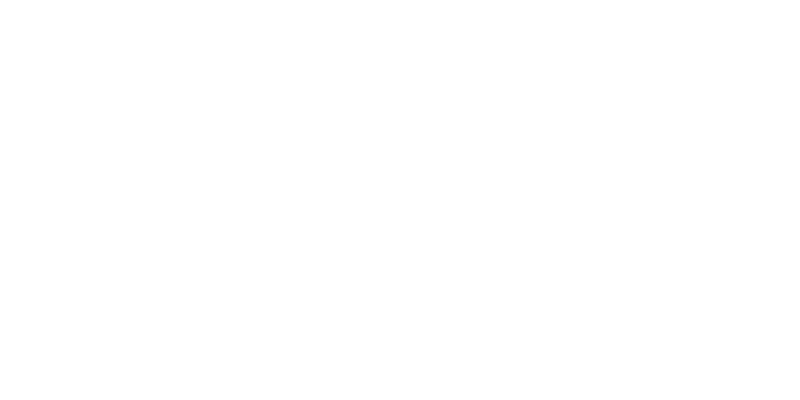

In [21]:
vega_view=dict(spec)
vega_view['data'][1]['url'] = vega_view['data'][0]['url'].replace('{{geostore_id}}','ca5bfde08587530e76c17fe48362a01d')
print(vega_view)
Vega(vega_view)